In [29]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Environments

There are two environments at the moment. The standard `VacuumEnvironment` and the `BadVacuumEnvironment`. The former is the main solution to the `exercise 2.11` and the latter is a part of `exercise 2.14`.

In [30]:
class VacuumEnvironment:
    def __init__(self, width, height, dirt_density):
        """
        Generates the VacuumEnvironment with the given width and height.
        It also sets the agent's initial location and randomly distributes dirt across the environment.
        """

        self.width = width
        self.height = height
        self.agent_location = ((width - 1) // 2, (height - 1) // 2)
        self.step = 0

        if dirt_density > 1:
            raise ValueError("Percentage of dirt density exceeds 100%")

        self.total_dirt_patches = int(width * height * dirt_density)
        self.dirt_locations = {(random.randint(0, width - 1), random.randint(0, height - 1)) for _ in
                               range(self.total_dirt_patches)}

    def is_dirty(self, location):
        """Check if the given location contains dirt."""

        return location in self.dirt_locations

    def clean(self, location):
        """Remove dirt from the given location."""
        if location in self.dirt_locations:
            self.dirt_locations.remove(location)
            self.total_dirt_patches -= 1

    def move_agent(self, action):
        """Move the agent according to the given action."""
        x, y = self.agent_location
        if action == 'UP' and y > 0:
            self.agent_location = (x, y - 1)
        elif action == 'DOWN' and y < self.height - 1:
            self.agent_location = (x, y + 1)
        elif action == 'LEFT' and x > 0:
            self.agent_location = (x - 1, y)
        elif action == 'RIGHT' and x < self.width - 1:
            self.agent_location = (x + 1, y)

    def percept(self):
        """Get the percept of the agent: current location and dirt presence."""
        return self.agent_location, self.is_dirty(self.agent_location)

    def execute_action(self, action):
        """Execute the given action."""
        self.move_agent(action)

        if action == 'SUCK':
            self.clean(self.agent_location)

In [31]:
class BadVacuumEnvironment:
    def __init__(self, width, height, dirt_density, empty_space_probability):
        """
        Initialize the Maze environment with width, height, dirt density, and empty space probability.

        Args:
          width: Width of the environment (grid size).
          height: Height of the environment (grid size).
          dirt_density: Percentage of open spaces in the maze to fill with dirt.
          empty_space_probability: Probability of a cell being an empty space (walkable area).
        """
        self.width = width
        self.height = height
        self.maze_map = self.generate_maze(width, height, empty_space_probability)
        self.dirt_locations = set()
        self.step = 0

        # Dirt management (adapted from VacuumEnvironment)
        if dirt_density > 100:
            raise ValueError("Percentage of dirt density exceeds 100%")
        self.total_dirt_patches = int(dirt_density * width * height)
        self.generate_dirt(dirt_density)

        self.agent_location = self.find_random_open_space()  # Find random starting position

        # Define valid actions the agent can take
        self.valid_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'SUCK']

    def generate_maze(self, width, height, empty_space_probability):
        """Generate a random maze with empty spaces within the given width and height."""
        maze_map = [[1] * (width * 2 - 1) for _ in range(height * 2 - 1)]  # Initialize with walls

        def dfs(x, y):
            maze_map[y][x] = 0  # Mark the cell as open space
            directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
            random.shuffle(directions)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width * 2 - 1 and 0 <= ny < height * 2 - 1 and maze_map[ny][nx] == 1:
                    maze_map[y + dy // 2][x + dx // 2] = 0  # Break the wall
                    dfs(nx, ny)

        start_x, start_y = random.randint(0, (width - 1) * 2), random.randint(0, (height - 1) * 2)
        dfs(start_x, start_y)

        for y in range(height * 2 - 1):
            for x in range(width * 2 - 1):
                if maze_map[y][x] == 1 and random.random() > empty_space_probability:
                    maze_map[y][x] = 0  # Convert some walls to open space based on empty_space_probability

        return maze_map

    def find_random_open_space(self):
        """Find a random open space (0) in the maze map as the starting position."""
        while True:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if self.maze_map[y][x] == 0:
                return x, y

    def generate_dirt(self, dirt_density):
        """Generate dirt patches on open spaces (0) in the maze map."""
        count = 0
        while count < self.total_dirt_patches:
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            if self.maze_map[y][x] == 0 and (x, y) not in self.dirt_locations:
                self.dirt_locations.add((x, y))
                self.maze_map[y][x] = 2  # Update maze_map to mark dirt locations
                count += 1

    def is_dirty(self, location):
        """Check if the given location contains dirt."""
        return location in self.dirt_locations

    def is_valid_location(self, location):
        """Check if the given location is within bounds and a valid open space."""
        x, y = location
        return 0 <= x < self.width and 0 <= y < self.height and self.maze_map[y][x] != 1

    def move_agent(self, action):
        """
        Move the agent according to the given action, but only if it's a valid action
        and leads to a valid location.

        Args:
          action: The action the agent wants to take (UP, DOWN, LEFT, RIGHT, SUCK).
        """
        if action not in self.valid_actions:
            raise ValueError(f"Invalid action: {action}. Valid actions are: {self.valid_actions}")

        x, y = self.agent_location
        new_x, new_y = x, y

        if action == 'UP' and y > 0:
            new_y -= 1
        elif action == 'DOWN' and y < self.height - 1:
            new_y += 1
        elif action == 'LEFT' and x > 0:
            new_x -= 1
        elif action == 'RIGHT' and x < self.width - 1:
            new_x += 1

        # Check if the new location is valid (within bounds and an open space)
        new_location = (new_x, new_y)
        if action == 'SUCK':
            self.clean((x, y))  # Clean even if the agent stays in the same location for 'SUCK'
        elif self.is_valid_location(new_location):
            self.agent_location = new_location

    def percept(self):
        """Get the perception of the agent: current location and dirt presence."""
        current_location = self.agent_location
        is_dirty = self.is_dirty(current_location)
        return current_location, is_dirty

    def execute_action(self, action):
        """Execute the given action (move or suck)."""
        # Currently only handles movement actions (defined in move_agent)
        self.move_agent(action)

    def clean(self, location):
        """Clean dirt at the given location."""
        if location in self.dirt_locations:
            self.dirt_locations.remove(location)
            self.maze_map[location[1]][location[0]] = 0  # Update maze_map to mark cleaned location
            self.total_dirt_patches -= 1

## Types of Agents

### Simple Reflex Agent

This agent simply follow two directives, suck up dirt if it's standing in a dirty spot and head right if it's clean.

### Simple Reflex _Random_ Agent

This agent chooses to either suck if the ground below it is dirty or turn in a randomly selected direction.


In [32]:
def pure_simple_reflex_agent(percept):
    """
    Pure simple reflex agent that takes action based on percept.
    If location is dirty, it SUCKs, otherwise, it moves in a predefined direction.
    """

    location, is_dirty = percept

    if is_dirty:
        return 'SUCK'  # If the location is dirty, the agent SUCKs.
    else:
        # If the location is clean, the agent moves in a predefined direction.
        # For example, it might always choose to move 'RIGHT'.
        return 'RIGHT'  # Predefined direction to move when the location is clean.

In [33]:
def simple_reflex_random_agent(percept):
    """
    Simple reflex agent that takes action based on percept.
    If location is dirty, it SUCKs, otherwise, it moves randomly.
    """

    location, is_dirty = percept

    if is_dirty:
        return 'SUCK'
    else:
        return random.choice(['UP', 'DOWN', 'LEFT', 'RIGHT'])

In [34]:
class ExplorationAgent:
    def __init__(self):
        self.visited_locations = set()  # Set to store visited locations
        self.current_location = None  # Variable to store current location

    def perceive_and_act(self, percept):
        """
        Perceive the environment and take action accordingly.

        Args:
            percept: A tuple containing current location and dirt presence (in this case, dirt presence is not used).
        
        Returns:
            Action to be taken by the agent.
        """
        location, _ = percept
        self.current_location = location

        # Add current location to visited locations
        self.visited_locations.add(location)

        # Explore if there are undiscovered locations nearby
        undiscovered_locations = self.get_undiscovered_locations()
        if undiscovered_locations:
            return self.explore(undiscovered_locations)
        else:
            # If no undiscovered locations nearby, return to a previously visited location
            return self.return_to_visited()

    def get_undiscovered_locations(self):
        """
        Get undiscovered locations nearby the current location.

        Returns:
            List of undiscovered locations nearby.
        """
        x, y = self.current_location
        nearby_locations = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]  # Assuming movement is possible in 4 directions
        undiscovered = [loc for loc in nearby_locations if loc not in self.visited_locations]
        return undiscovered

    def explore(self, undiscovered_locations):
        """
        Choose an undiscovered location to explore randomly.

        Args:
            undiscovered_locations: List of undiscovered locations nearby.

        Returns:
            Action to move towards the chosen undiscovered location.
        """
        if undiscovered_locations:
            return self.move_towards(random.choice(undiscovered_locations))
        else:
            return 'NO_OP'  # No undiscovered locations nearby

    def move_towards(self, location):
        """
        Move towards a given location.

        Args:
            location: Location to move towards.

        Returns:
            Action to move towards the given location.
        """
        x, y = self.current_location
        target_x, target_y = location

        if target_x > x:
            return 'RIGHT'
        elif target_x < x:
            return 'LEFT'
        elif target_y > y:
            return 'DOWN'
        elif target_y < y:
            return 'UP'
        else:
            return 'NO_OP'  # Already at the target location

    def return_to_visited(self):
        """
        Choose a previously visited location to return to.

        Returns:
            Action to move towards a previously visited location.
        """
        if len(self.visited_locations) > 1:  # Ensure there's at least one visited location other than the current
            return self.move_towards(random.choice(list(self.visited_locations - {self.current_location})))
        else:
            return 'NO_OP'  # Only current location has been visited

## Visualizers

These visualizers are disabled by default. The lines that trigger them can be ***found in each simulation run, within the step execution for loop***.

Make sure to edit the path found in lines `41` & `43` respectively so that when you run the visualizers you can find the images right where you want them to be.

In [35]:
def visualize_good_environment_image(environment, cell_size=20):
    """Create an image representation of the environment generated by the VacuumEnvironment class."""
    img_width = environment.width * cell_size
    img_height = environment.height * cell_size
    image = Image.new("RGB", (img_width, img_height), "black")
    draw = ImageDraw.Draw(image)

    # Draw unit on the image
    for y in range(environment.height):
        for x in range(environment.width):
            draw.rectangle(
                [x * cell_size, y * cell_size, (x + 1) * cell_size, (y + 1) * cell_size],
                outline="black", fill="lightgray"
            )

    # Draw agent on the image
    agent_x, agent_y = environment.agent_location
    agent_size = cell_size // 2  # Adjust the size of the agent rectangle
    agent_rect = [
        agent_x * cell_size + (cell_size - agent_size) // 2,
        agent_y * cell_size + (cell_size - agent_size) // 2,
        agent_x * cell_size + (cell_size - agent_size) // 2 + agent_size,
        agent_y * cell_size + (cell_size - agent_size) // 2 + agent_size
    ]
    draw.rectangle(agent_rect, outline="black", fill="blue")

    # Draw dirt on the image (handle case where there's no dirt)
    if environment.dirt_locations:  # Check if there's any dirt before iterating
        for dirt_location in environment.dirt_locations:
            dirt_x, dirt_y = dirt_location
            draw.rectangle(
                [dirt_x * cell_size, dirt_y * cell_size, (dirt_x + 1) * cell_size, (dirt_y + 1) * cell_size],
                outline="black", fill="brown"
            )

    # Ensure the save location exists
    # TODO: Change the path below to fit your computers OS and preferred location
    os.makedirs("/home/panchi/Desktop/steps/", exist_ok=True)

    # Save the image with an enumerated filename
    image_filename = os.path.join("/home/panchi/Desktop/steps/", f'image_{environment.step}_good.png')
    environment.step += 1
    image.save(image_filename)

In [36]:
def visualize_bad_environment_image(environment, cell_size=20):
    """Create an image representation of the environment generated by the ModifiedVacuumEnvironment class."""
    img_width = environment.width * cell_size
    img_height = environment.height * cell_size
    image = Image.new("RGB", (img_width, img_height), "black")
    draw = ImageDraw.Draw(image)

    # Draw units on the image (maze map)
    for y in range(environment.height):
        for x in range(environment.width):
            if environment.maze_map[y][x] == 0:
                draw.rectangle(
                    [x * cell_size, y * cell_size, (x + 1) * cell_size, (y + 1) * cell_size],
                    outline="black", fill="lightgray"
                )
            elif environment.maze_map[y][x] == 1:
                draw.rectangle(
                    [x * cell_size, y * cell_size, (x + 1) * cell_size, (y + 1) * cell_size],
                    outline="black", fill="black"
                )
    # Draw dirt on the image
    for dirt_location in environment.dirt_locations:
        dirt_x, dirt_y = dirt_location
        draw.rectangle(
            [dirt_x * cell_size, dirt_y * cell_size, (dirt_x + 1) * cell_size, (dirt_y + 1) * cell_size],
            outline="black", fill="brown"
        )
    # Draw agent on the image
    agent_x, agent_y = environment.agent_location
    agent_size = cell_size // 2  # Adjust the size of the agent rectangle
    agent_rect = [
        agent_x * cell_size + (cell_size - agent_size) // 2,
        agent_y * cell_size + (cell_size - agent_size) // 2,
        agent_x * cell_size + (cell_size - agent_size) // 2 + agent_size,
        agent_y * cell_size + (cell_size - agent_size) // 2 + agent_size
    ]
    draw.rectangle(agent_rect, outline="black", fill="blue")

    # Ensure the save location exists
    os.makedirs("/home/panchi/Desktop/steps/", exist_ok=True)

    # Save the image with an enumerated filename
    image_filename = os.path.join("/home/panchi/Desktop/steps/", f'image_{environment.step}_bad.png')
    environment.step += 1
    image.save(image_filename)

## Simulation Runners

Please comment out the lines below where it says "Calculate overall average performance" when attempting to use the visualizers. Otherwise, you will get division by zero errors.

In [37]:
def run_simulation_with_normal_env(agent_program, num_steps, num_runs, width, height, dirt_density, performance_avg_multiplier):
    """
    Run simulation for the given number of steps and runs.
    Returns performance per average runs.
    """

    performance_per_avg_runs = []
    total_performance = 0

    for run in range(1, num_runs + 1):
        environment = VacuumEnvironment(width, height, dirt_density)
        for step in range(num_steps):
            percept = environment.percept()
            if agent_program == ExplorationAgent:
                action = agent_program().perceive_and_act(percept)  # Pass the percept to perceive_and_act method
            else:
                action = agent_program(percept)
            environment.execute_action(action)
            visualize_good_environment_image(environment)

        cleaned_dirt_patches = environment.total_dirt_patches
        total_performance += cleaned_dirt_patches

        if run % performance_avg_multiplier == 0:
            avg_performance = total_performance / performance_avg_multiplier
            performance_per_avg_runs.append(avg_performance)
            total_performance = 0

    # Calculate overall average performance
    # overall_avg_performance = sum(performance_per_avg_runs) / len(performance_per_avg_runs)
    # print("Overall average performance across all runs:", overall_avg_performance)

    # return performance_per_avg_runs


In [38]:
def run_simulation_with_bad_env(agent_program, num_steps, num_runs, width, height, dirt_density, performance_avg_multiplier):
    """
    Run simulation for the given number of steps and runs.
    Returns performance per average runs.
    """

    performance_per_avg_runs = []
    total_performance = 0

    for run in range(1, num_runs + 1):
        environment = BadVacuumEnvironment(width, height, dirt_density, empty_space_probability=0.65)
        initialDirtPatchCount = environment.total_dirt_patches
        for step in range(num_steps):
            percept = environment.percept()  # Get the percept from the environment
            action = agent_program(percept)  # Call the agent program with the percept
            environment.execute_action(action)
            # visualize_bad_environment_image(environment)

        cleaned_dirt_patches = initialDirtPatchCount - environment.total_dirt_patches
        total_performance += cleaned_dirt_patches

        if run % performance_avg_multiplier == 0:
            avg_performance = total_performance / performance_avg_multiplier
            performance_per_avg_runs.append(avg_performance)
            total_performance = 0

    # Calculate overall average performance
    overall_avg_performance = sum(performance_per_avg_runs) / len(performance_per_avg_runs)
    print("Overall average performance across all runs in bad environment:", overall_avg_performance)

    return performance_per_avg_runs

## Simulation Settings


#### Visualization

In order to not crash or fry your computer when running the visualizers we recommend to set the amount of runs to 1 for visualizing. As well as commenting out the parts below the lines that contain the comment "Calculate overall average performance" in both simulation runners (otherwise they emit divide by zero errors).

This will create an image for every single step that is executed in each environment. If you would like to quickly visualize them all in a video, we recommend using `ffmpeg` to stitch all the images together as a 10-second video using the following ffmpeg commands.

For the "good/normal" environment use the following command in the directory you chose for output earlier use:
`ffmpeg -framerate 10 -i "image_%d_good.png" -c:v libx264 -r 30 -pix_fmt yuv420p output_video_good_map.mp4`

For the "bad" environment use the following command in the directory you chose for output earlier use:
`ffmpeg -framerate 10 -i "image_%d_bad.png" -c:v libx264 -r 30 -pix_fmt yuv420p output_video_bad_map.mp4`

In [39]:
# Run the simulation for 100 steps and calculate average performance over every 10 runs
num_steps = 100
num_runs = 1
width = 7
height = 7
dirt_density = 0.20  # Percentage of the environment you want dirty
performance_avg_multiplier = 100  # Adjust as needed

In [41]:
# # Call the simulation for pure simple reflex agent
# performance_pure_simple_good_env = run_simulation_with_normal_env(pure_simple_reflex_agent, num_steps, num_runs, width, height, dirt_density, performance_avg_multiplier)

# # Call the simulation for simple reflex random agent
# performance_rand_agent_good_env = run_simulation_with_normal_env(simple_reflex_random_agent, num_steps, num_runs, width, height, dirt_density, performance_avg_multiplier)

# performance_rand_agent_bad_env = run_simulation_with_bad_env(simple_reflex_random_agent, num_steps, num_runs, width, height, dirt_density, performance_avg_multiplier)

# Call the simulation for the state retaining agent
performance_state_agent_good_env = run_simulation_with_normal_env(ExplorationAgent, num_steps,num_runs, width, height, dirt_density, performance_avg_multiplier)

## Performance Comparison Plots

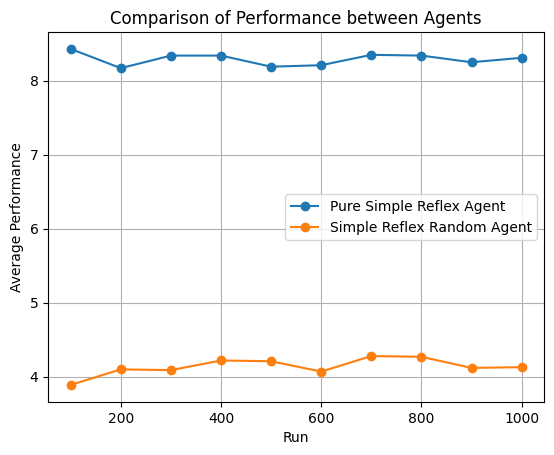

In [13]:
# Plot the simple vs random agent results
plt.plot(range(100, num_runs + 1, 100), performance_pure_simple_good_env, marker='o', linestyle='-',
         label='Pure Simple Reflex Agent')
plt.plot(range(100, num_runs + 1, 100), performance_rand_agent_good_env, marker='o', linestyle='-',
         label='Simple Reflex Random Agent')

plt.xlabel('Run')
plt.ylabel('Average Performance')
plt.title('Comparison of Performance between Agents')
plt.legend()
plt.grid(True)

plt.show()

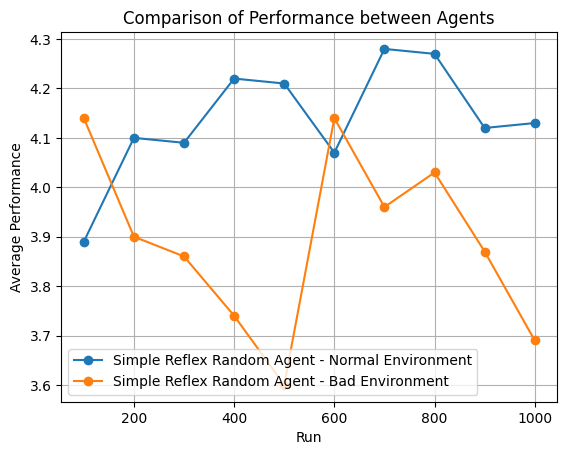

In [14]:
# # Plot the random in good and bad map results
plt.plot(range(100, num_runs + 1, 100), performance_rand_agent_good_env, marker='o', linestyle='-',
         label='Simple Reflex Random Agent - Normal Environment')
plt.plot(range(100, num_runs + 1, 100), performance_rand_agent_bad_env, marker='o', linestyle='-',
         label='Simple Reflex Random Agent - Bad Environment')

plt.xlabel('Run')
plt.ylabel('Average Performance')
plt.title('Comparison of Performance between Agents')
plt.legend()
plt.grid(True)

plt.show()

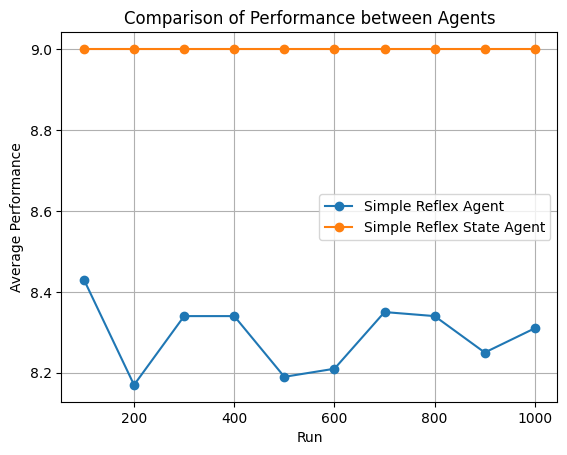

In [15]:
# # Plot the random in good and bad map results
# NOTE: Our state agent seems to have died somehow and won't suck or remember anything...
plt.plot(range(100, num_runs + 1, 100), performance_pure_simple_good_env, marker='o', linestyle='-',
         label='Simple Reflex Agent')
plt.plot(range(100, num_runs + 1, 100), performance_state_agent_good_env, marker='o', linestyle='-',
         label='Simple Reflex State Agent')

plt.xlabel('Run')
plt.ylabel('Average Performance')
plt.title('Comparison of Performance between Agents')
plt.legend()
plt.grid(True)

plt.show()